In [41]:
import numpy as np
import re
import os
import sys
import time
from collections import defaultdict
from string import digits
from gensim import corpora, models, similarities, matutils
import networkx as nx
import string
import pickle

import csv
import matplotlib.pyplot as plt
from sklearn import manifold

from sklearn.cluster import KMeans


In [42]:
# loads data
dictionary = corpora.Dictionary.load('database/Burak(4).dict')
corpus = corpora.MmCorpus('database/Burak(4).mm')
lda = models.LdaModel.load("database/Burak(4).lda")
with open('database/Burak(4).pickle', 'rb') as f:
    userList = pickle.load(f)

In [43]:
index = similarities.MatrixSimilarity(lda[corpus])
#index.save("Burak(10).index")

In [44]:
similarityMatrix = []

for i in range(len(corpus)):
    vec_lda = lda[corpus[i]]
    sims = index[vec_lda]
    sims = sorted(enumerate(sims), key=lambda item: -item[1])
    similarityMatrix.append(sims)
    
# vec_lda = lda[corpus[557]]

# print(similarityMatrix[0])

In [45]:
distanceMatrix = np.zeros((len(corpus), len(corpus)))

#for i in range(len(corpus)):
#    for tuples in similarityMatrix[i]:
#       print(tuples)
#        break

In [115]:
dt = [('len', float)]

distanceMatrix = np.zeros((len(corpus), len(corpus)))

for i in range(len(corpus)):
    for j in range(len(similarityMatrix[i])):
        if i == similarityMatrix[i][j][0]:
            distanceMatrix[i][similarityMatrix[i][j][0]] = 0
        else:
            distanceMatrix[i][similarityMatrix[i][j][0]] = (1-similarityMatrix[i][j][1])
            distanceMatrix[similarityMatrix[i][j][0]][i] = (1-similarityMatrix[i][j][1])

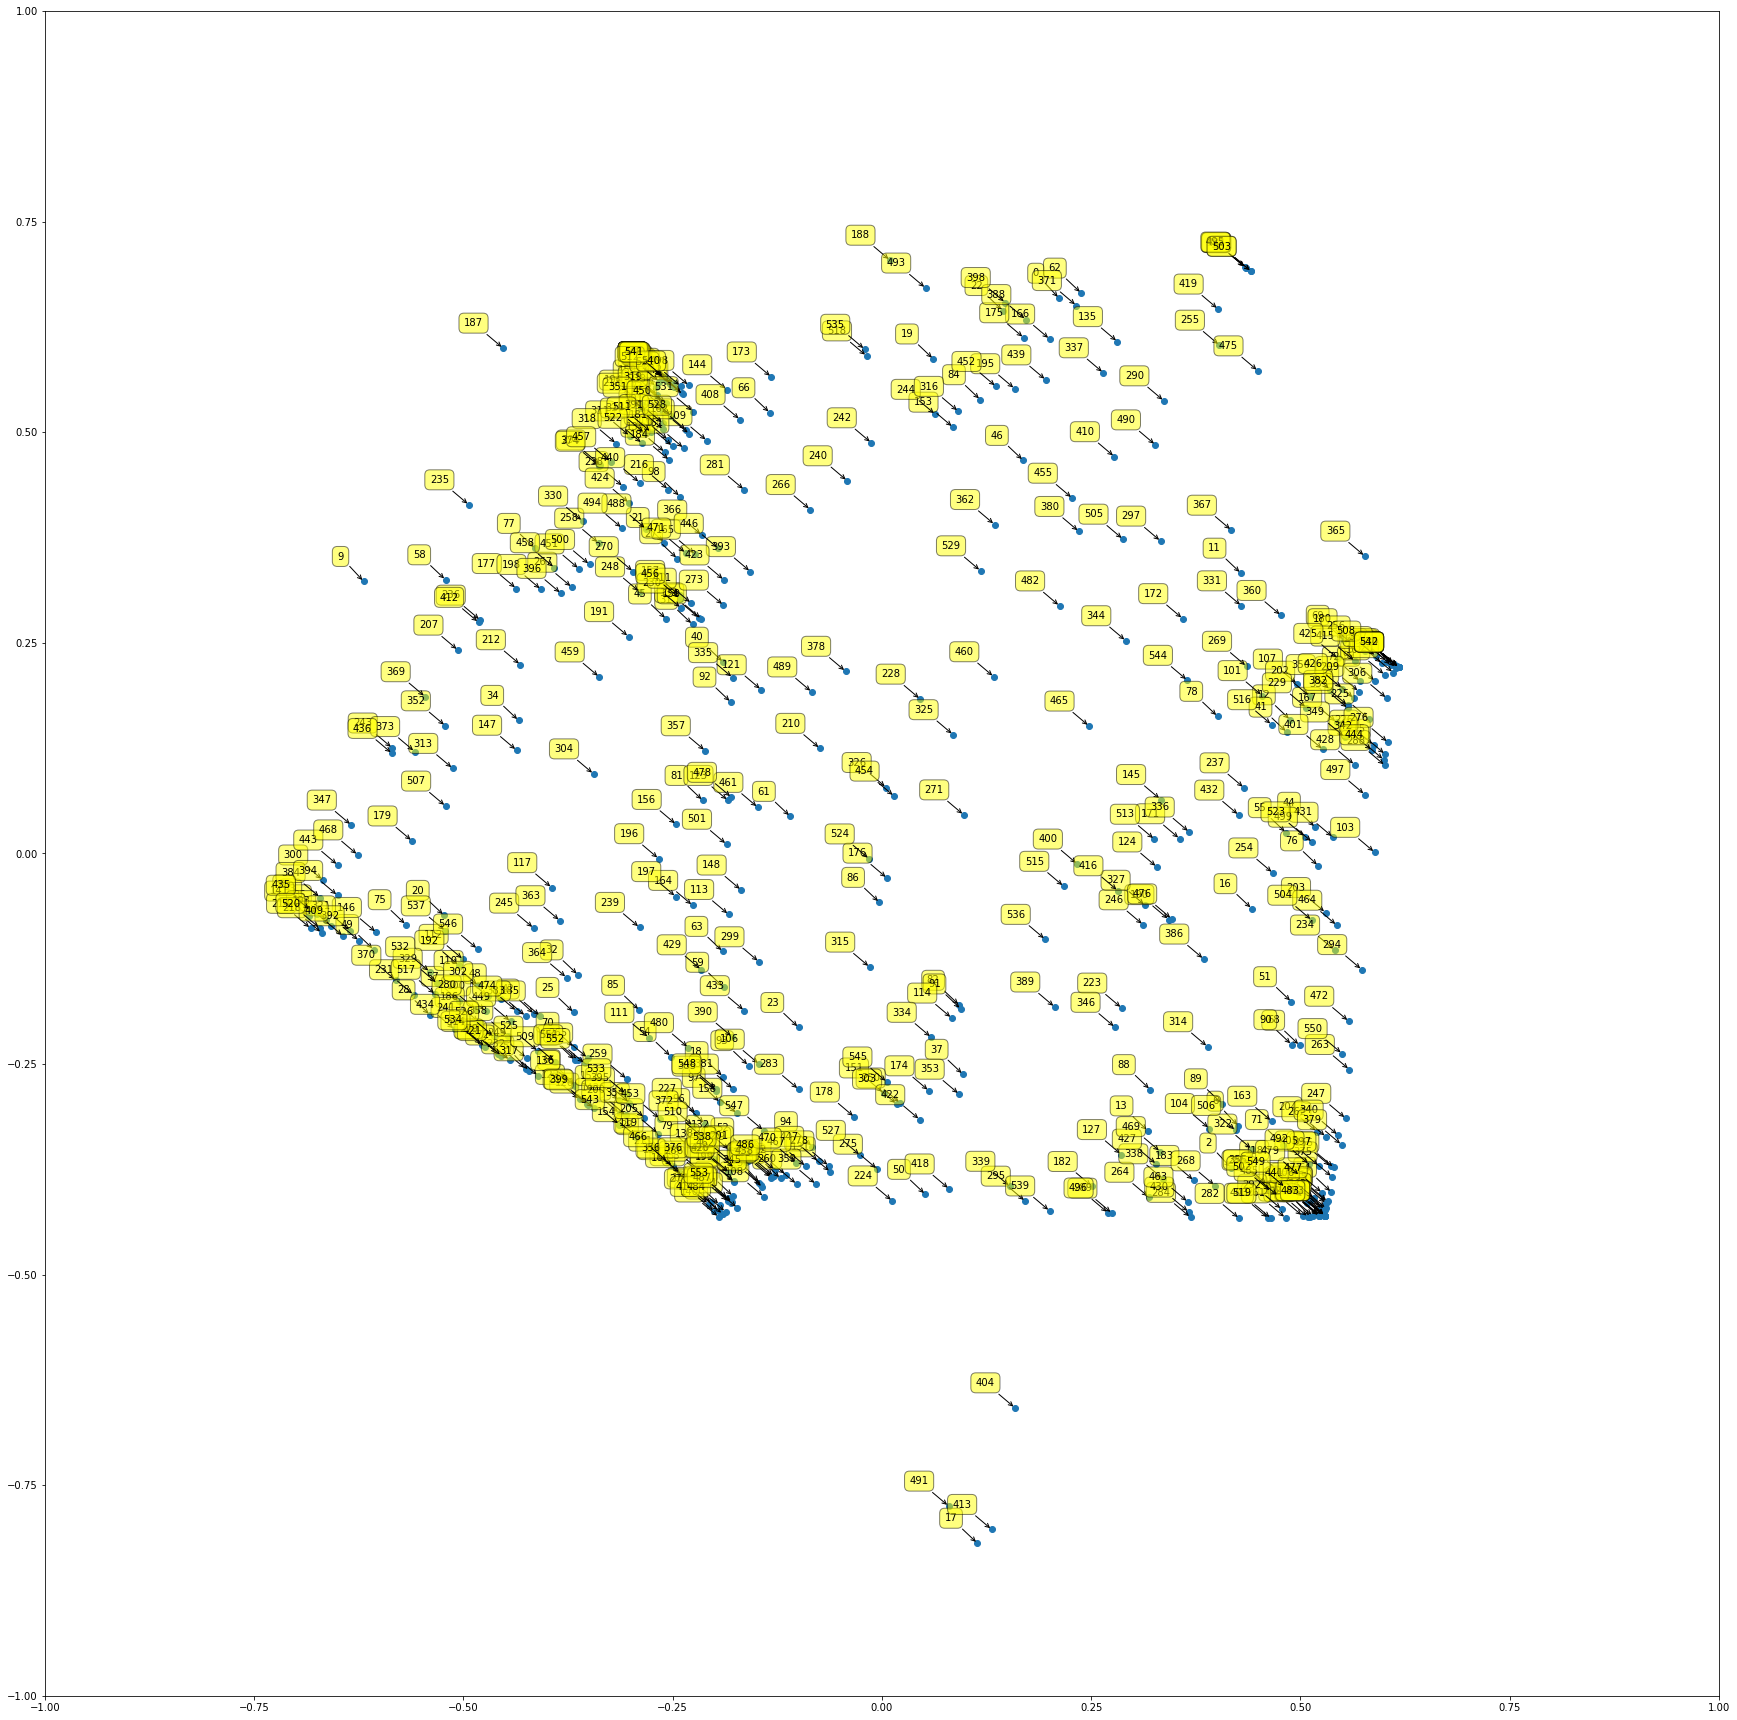

In [117]:
# loads data (4)

dists = distanceMatrix
cities = []
for i in range(len(distanceMatrix)):
    cities.append(i)
    #dists.append(map(float , d[1:-1]))

adist = distanceMatrix
amax = np.amax(adist)
adist /= amax

mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(adist)

coords = results.embedding_

plt.figure(figsize=(30,30))
plt.axis([-1, 1, -1, 1])
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
for label, x, y in zip(cities, coords[:, 0], coords[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

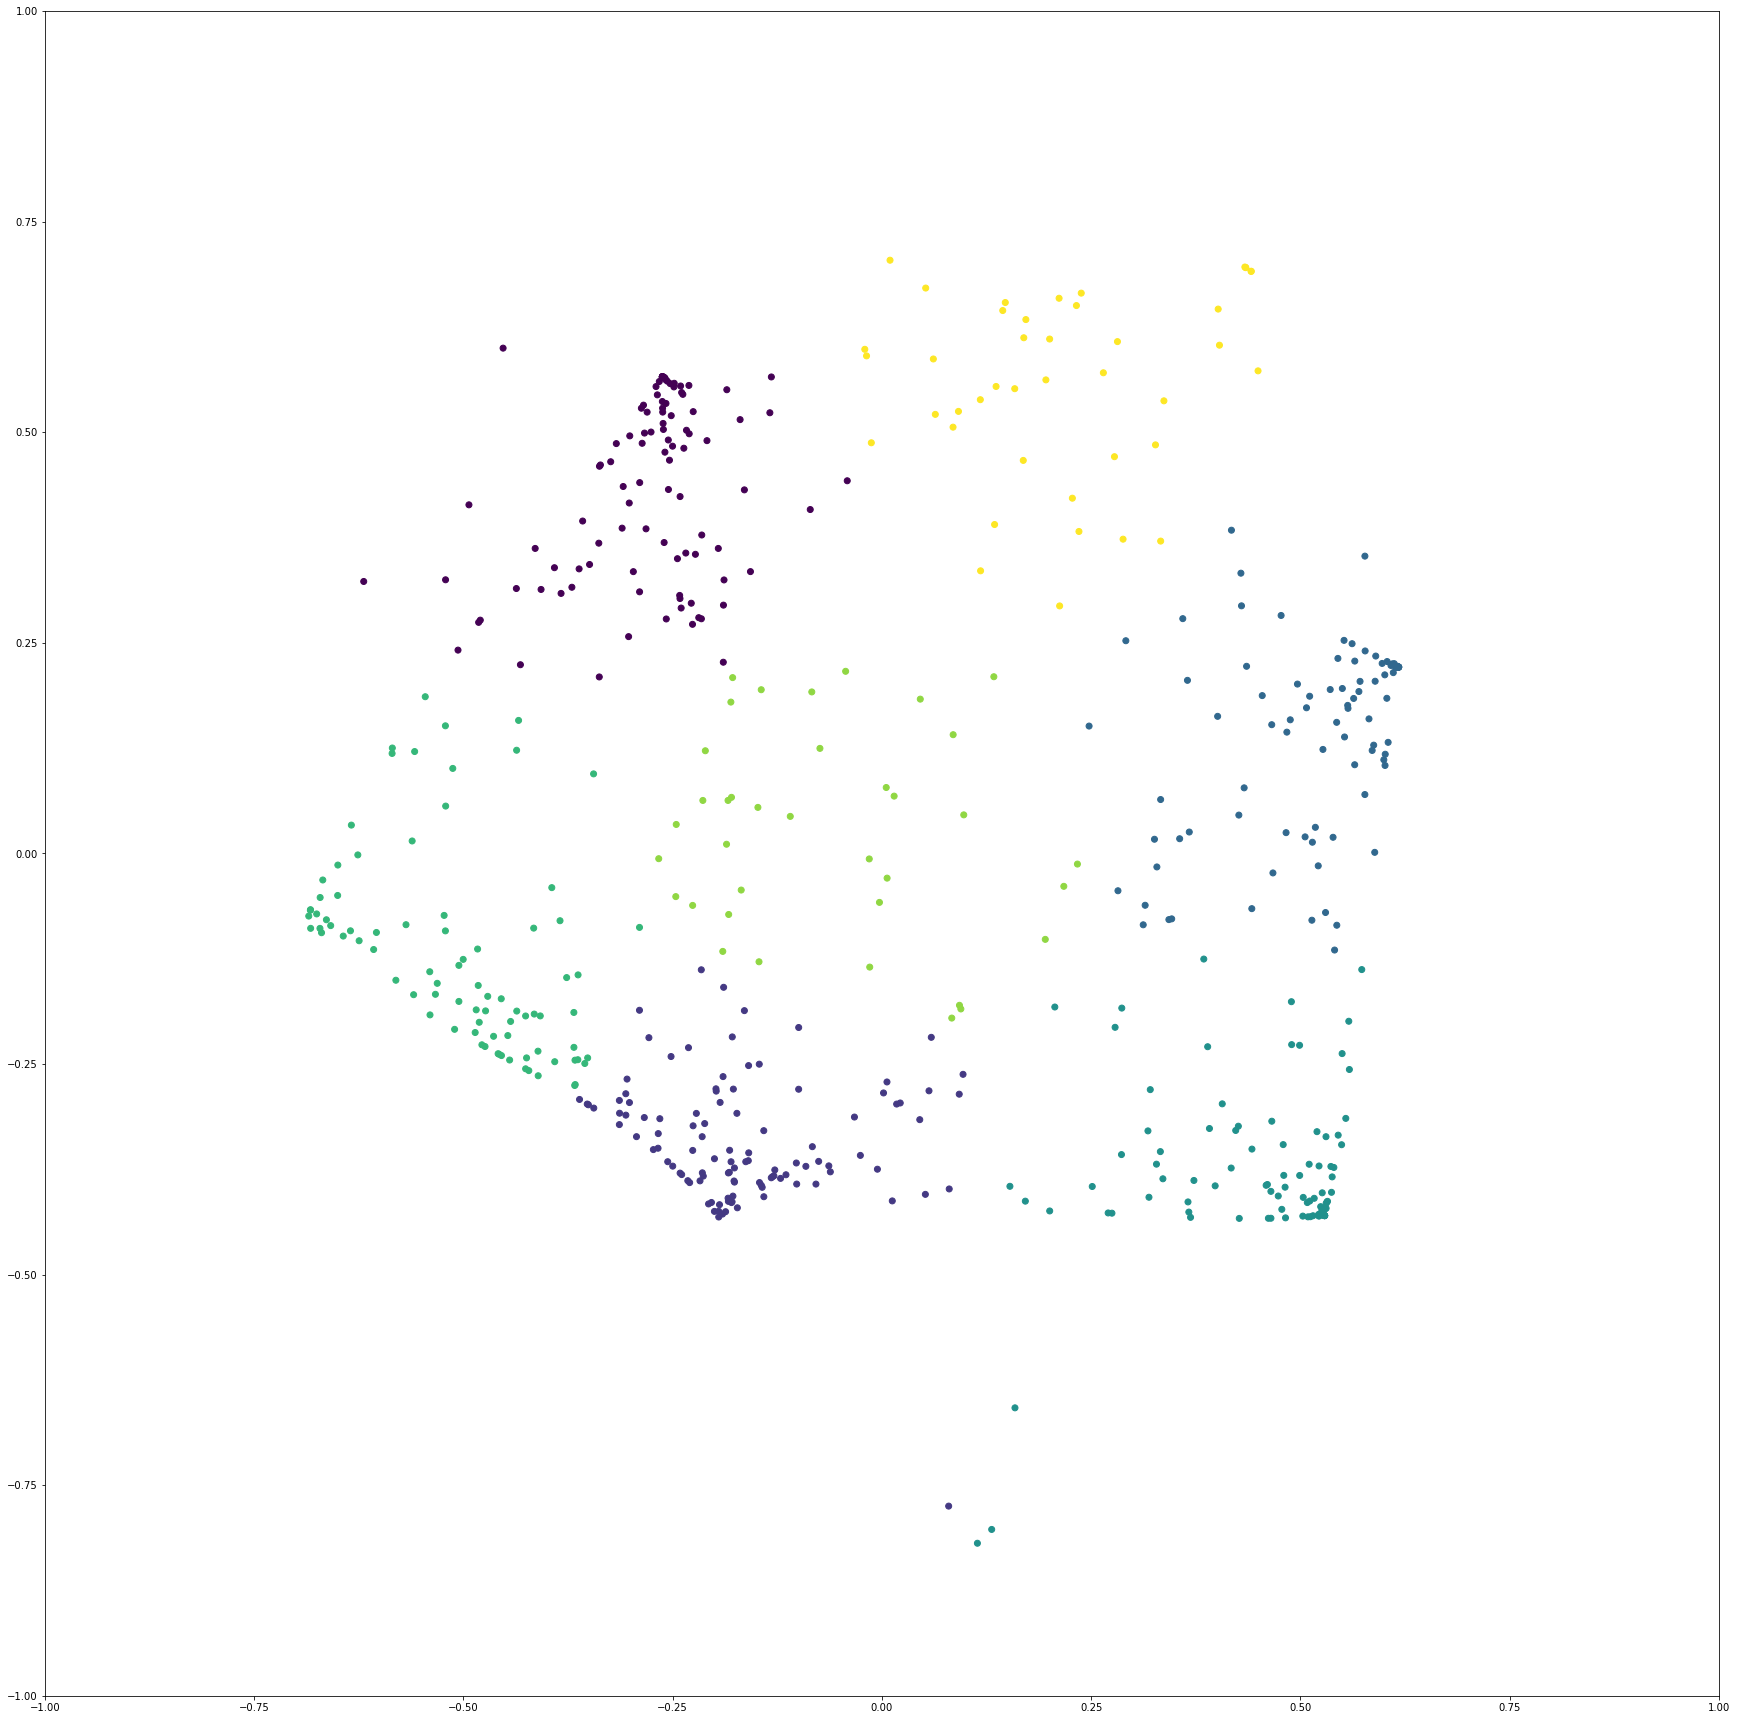

In [120]:
kmeansList = np.asarray(coords)
kmeans = KMeans(n_clusters=7, random_state=0).fit(kmeansList)

plt.figure(figsize=(30,30))
plt.axis([-1, 1, -1, 1])
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o', c = kmeans.labels_
    )


plt.show()

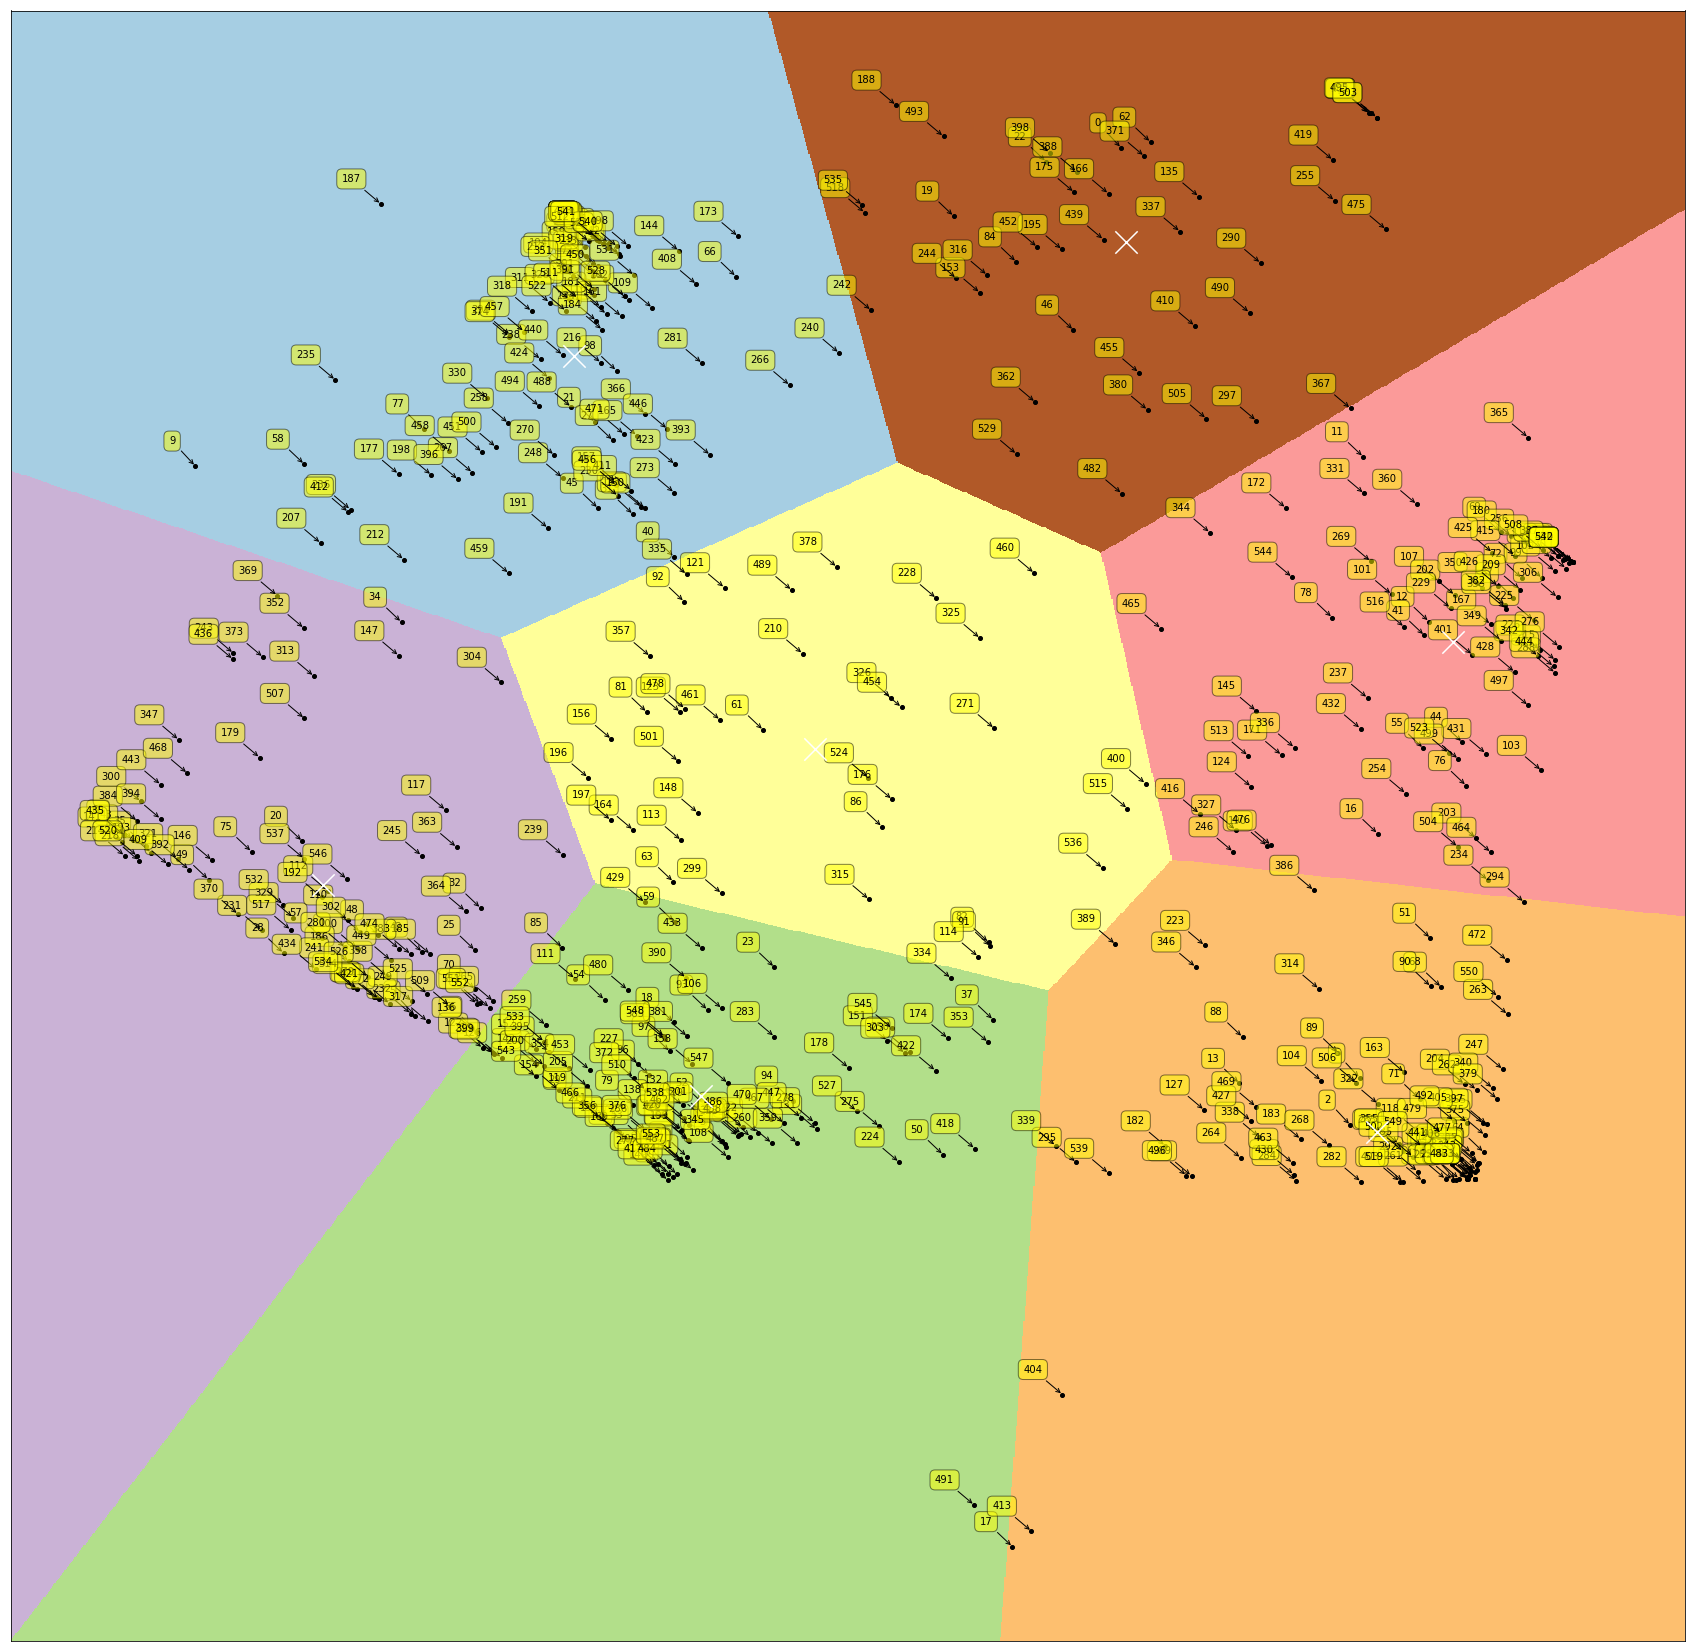

In [121]:
reduced_data = coords

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .001     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 0.1, reduced_data[:, 0].max() + 0.1
y_min, y_max = reduced_data[:, 1].min() - 0.1, reduced_data[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
plt.figure(figsize=(30,30))
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=8)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=500, linewidths=3,
            color='w', zorder=10)
for label, x, y in zip(cities, coords[:, 0], coords[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

#plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
#          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [148]:
kmeansDict = {}
kmeansTopics = []
for i in range(7):
    kmeansDict[i] = []
    kmeansTopics.append([0]*7)
    
for ind, lab in enumerate(kmeans.labels_):
    kmeansDict[lab].append(ind)

for key, docs in kmeansDict.items():
    for d in docs:
        mx = 0
        mxInd = 0
        for t in lda.get_document_topics(lda[corpus[d]]):
            if t[1] > mx:
                mx = t[1]
                mxInd = t[0]
        kmeansTopics[key][mxInd] = kmeansTopics[key][mxInd] + mx    

for i, clusters in enumerate(kmeansTopics):
    clusters = [c/sum(clusters) for c in clusters]
    kmeansTopics[i] = clusters
    print(max(kmeansTopics[i]))
        
centerLabels = [np.argmax(kT) for kT in kmeansTopics]
print(centerLabels)


0.786112661053
0.871336043221
1.0
0.961730682713
0.670729977302
0.496669213899
0.832745170541
[5, 2, 6, 0, 2, 6, 6]


In [52]:
lda.print_topics()

[(0,
  '0.008*"time" + 0.008*"work" + 0.008*"think" + 0.007*"peopl" + 0.005*"day" + 0.005*"need" + 0.005*"love" + 0.004*"look" + 0.004*"way" + 0.004*"much"'),
 (1,
  '0.056*"drone" + 0.011*"follow" + 0.011*"news" + 0.009*"construct" + 0.008*"fli" + 0.006*"latest" + 0.006*"industri" + 0.005*"video" + 0.005*"technolog" + 0.005*"sign"'),
 (2,
  '0.017*"robot" + 0.008*"design" + 0.007*"project" + 0.007*"print" + 0.006*"3dprint" + 0.006*"power" + 0.006*"control" + 0.006*"check" + 0.006*"video" + 0.006*"kit"'),
 (3,
  '0.022*"learn" + 0.016*"python" + 0.012*"data" + 0.009*"deep" + 0.008*"machin" + 0.008*"scienc" + 0.008*"work" + 0.006*"talk" + 0.006*"code" + 0.006*"neural"'),
 (4,
  '0.018*"stem" + 0.015*"learn" + 0.011*"today" + 0.010*"love" + 0.010*"day" + 0.009*"check" + 0.009*"code" + 0.008*"help" + 0.008*"educ" + 0.007*"build"'),
 (5,
  '0.025*"data" + 0.012*"today" + 0.011*"robot" + 0.008*"day" + 0.007*"talk" + 0.007*"join" + 0.007*"week" + 0.006*"articl" + 0.006*"open" + 0.006*"come"'

In [141]:
id1 = 542
id2 = 156

In [142]:
distanceMatrix[id1][id2]

1.0

In [143]:
print(lda.get_document_topics(bow = corpus[id1]))
print(lda.get_document_topics(bow = corpus[id2]))

[(2, 0.99985895210966658)]
[(0, 0.31459834831551126), (3, 0.16472877364203745), (5, 0.29276217788556008), (6, 0.21109271377613309)]


In [144]:
print(userList[id1])
print(userList[id2])

898423544
16558456
